/home/trkosire/Factorynet/hack_env/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Community 1: ['rail road maintenance shop', 'railway maintenance equipment', 'locomotive', 'railway tool', 'steam locomotive', 'railroad joining', 'railway infrastructure', 'train track', 'rail work cart', 'rail car with steel', 'railroad rail', 'rail vehicle', 'traintrack', 'rail', 'empty train car', 'rail guided tool', 'loose train track', 'engine', 'freight train', 'railroad', 'railway', 'train rail', 'train connection', 'steam train', 'rail car', 'rail yard', 'rail cart', 'railroad track', 'rail tool', 'flat rail car', 'train car', 'railroad joint', 'train engine']
Community 2: ['flapper grinding wheel', 'wheel', 'caster wheel', 'flap wheel grinding disk', 'power grinder', 'grinding stone in slovenia', 'belt drive motor', 'sanding flap wheel', 'belt grinding machine', 'rail head grinding machine', 'mill wheel', 'stone wheel', 'grinding plate', 'powered hand grinder', 'grinding wheel with tongue guard', 'makuta angle grinder', 'stump grinder', 'grinding tool', 'belt grinder', 'horse

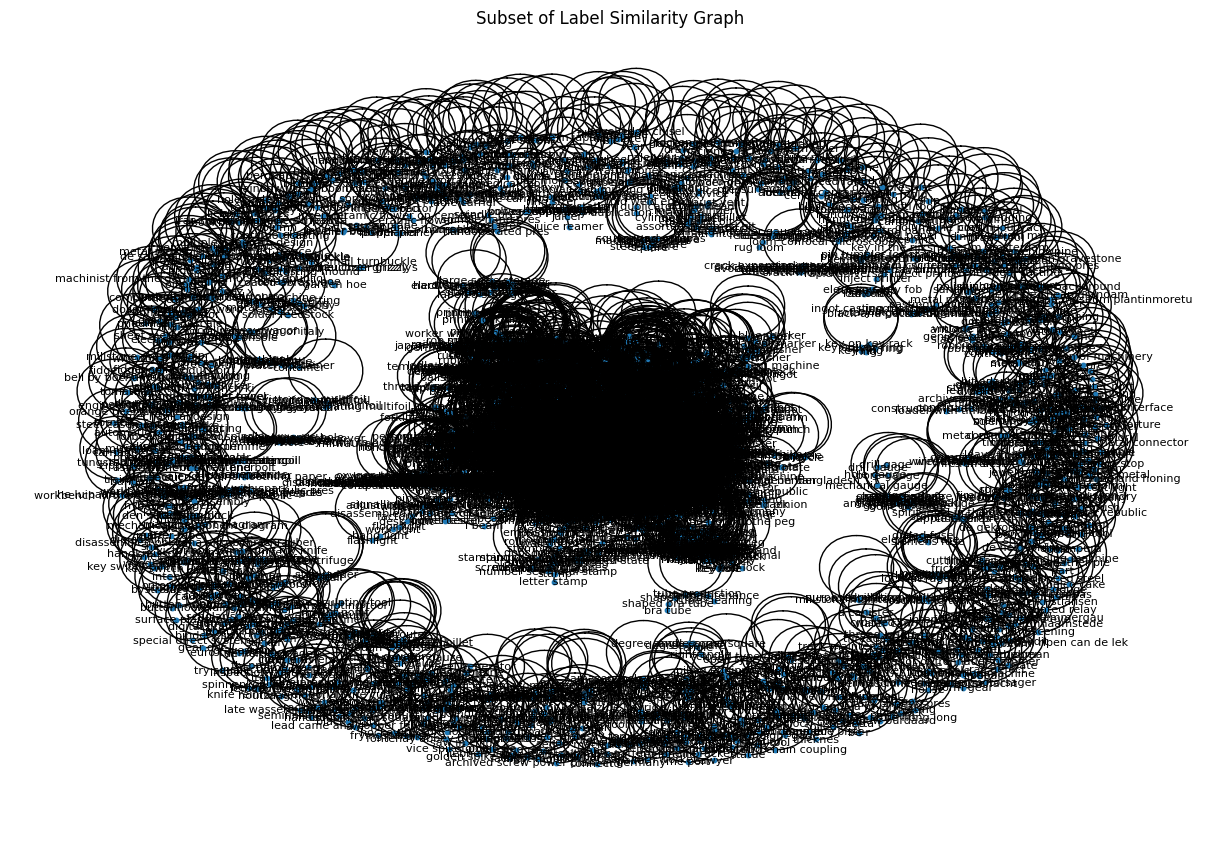

In [5]:
#approach was to create a graph where each string will be a node and each edge will connect two nodes with weight the similarity of those two strings.
#  You can use edit distance or Sorensen for that. I also set a threshold of 0.2 so that my graph will not be complete thus very computationally heavy.
#  After forming the graph you can use community detection algorithms to detect node communities. Each community is formed with nodes that have a lot of edges with each other, 
# so they will be very similar with each other. You can use networkx or igraph to form the graph and identify each community. So each community will be a cluster of strings. 
# I tested this approach with some string that I wanted to cluster. Here are some of the identified clusters.

import networkx as nx
from networkx.algorithms import community
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import pandas as pd
import inflect
from spellchecker import SpellChecker
import re


def similarity(s1, s2, model):
    embeddings = model.encode([s1, s2])
    return cosine_similarity([embeddings[0]], [embeddings[1]])[0][0]

def create_graph(strings, threshold, model):
    G = nx.Graph()
    embeddings = model.encode(strings)
    similarities = cosine_similarity(embeddings)
    for i in range(len(strings)):
        for j in range(i+1, len(strings)):
            if similarities[i][j] > threshold:
                G.add_edge(strings[i], strings[j], weight=similarities[i][j])
    return G

def get_communities(G):
    return community.louvain_communities(G)

# clean and normalize labels
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    return text.strip()

# clean_text("Cast5 Iron _ Door % Knocker")

model = SentenceTransformer('all-mpnet-base-v2')


spell = SpellChecker()

def correct_spelling(text):
    corrected_text = []
    for word in text.split():
        correction = spell.correction(word)
        if correction is None:
            correction = word  
        corrected_text.append(correction)
    return ' '.join(corrected_text)




p = inflect.engine()

def inflect_text(text):
    singularized_text = []
    for word in text.split():  
        singular_form = p.singular_noun(word)
        if singular_form:  
            singularized_text.append(singular_form)
        else:
            singularized_text.append(word)  
    return ' '.join(singularized_text)

df  = pd.read_csv("final_data_exploration.csv")
df['label'] = df['label'].str.lower()
df['label'] = df['label'].apply(clean_text)
df['label'] = df['label'].apply(correct_spelling)
df['label'] = df['label'].apply(inflect_text)
unique_words = df['label'].tolist()


strings = list(unique_words)
G = create_graph(strings, 0.7, model)  # Increased threshold for stricter similarity
communities = get_communities(G)

for i, comm in enumerate(communities):
    print(f"Community {i+1}: {list(comm)}")  # Print first 5 members of each community

# Create a dictionary to map each label to its corresponding community
label_to_community = {}
for i, comm in enumerate(communities):
    for label in comm:
        label_to_community[label] = i

df['label_community'] = df['label'].map(label_to_community)

# Visualize a subset of the graph
subset = list(G.nodes())  # Visualize only the first 100 nodes
subgraph = G.subgraph(subset)

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(subgraph)
nx.draw(subgraph, pos, with_labels=True, node_size=10, font_size=8)
plt.title("Subset of Label Similarity Graph")
plt.show()




In [2]:
# take coomon word in each community and apply communities to them 
testval=  ['worker with milling machine', 'milling bit', 'milling machine chuck', 'milling machine', 'milling machine shop', 'rotary table', 'worker', 'milling machine rotary table', 'machine shop with tool', 'milling center tool', 'vertical csc milling machine', 'milling tool', 'milling machine with workpiece in shop', 'milling machine rotary table with workpiece', 'milling machine cutter storage', 'milling', 'milling machine workpiece in shop', 'horizontal milling machine', 'csc horizontal milling machine', 'milling machine boring tool', 'worker with large milling machine', 'ha milling machine', 'worker in factory with machining tool and part', 'mill rotary table with workpiece', 'milling equipment laboratory', 'milling machine workpiece', 'milling machine collet', 'milling cutter', 'factory worker', 'to varnsdorf who csc milling machine', 'milling cutter with workpiece', 'manual milling machine', 'milling machine with workpiece', 'mill rotary table', 'machine shop', 'vertical milling machine', 'csc milling machine', 'indelible milling cutter', 'desktop milling machine', 'manual milling center', 'worker in factory with machining tool', 'milling shop floor', 'construction worker', 'rotary table with workpiece', 'milling machine cutter', 'worker in factory', 'milling proces', 'worker with milling machine and workpiece']




def find_coomon_word(words):
    common_words = {}
    for word in words:
            if word in common_words:
                common_words[word] += 1
            else:
                common_words[word] = 1
    # return the wprd with highest frequency
    return max(common_words, key=common_words.get)


find_coomon_word(testval)


'worker with milling machine'

In [3]:
communities = list(communities)
communities = [list(comm) for comm in communities]
communities = [find_coomon_word(comm) for comm in communities]
communities

['metal die stamp', 'cutoff saw', 'hard hat with face mask', 'hex lock nut']

In [4]:
communities = list(communities)
communities = [list(comm) for comm in communities]
communities = [find_coomon_word(comm) for comm in communities]
strings = communities
G = create_graph(strings, 0.8, model)  # Increased threshold for stricter similarity
communities = get_communities(G)

for i, comm in enumerate(communities):
    print(f"Community {i+1}: {list(comm)}")  # Print first 5 members of each community

# Create a dictionary to map each label to its corresponding community
label_to_community = {}
for i, comm in enumerate(communities):
    for label in comm:
        label_to_community[label] = i

df['label_community'] = df['label'].map(label_to_community)

# Visualize a subset of the graph
subset = list(G.nodes())  # Visualize only the first 100 nodes
subgraph = G.subgraph(subset)

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(subgraph)
nx.draw(subgraph, pos, with_labels=True, node_size=10, font_size=8)
plt.title("Subset of Label Similarity Graph")
plt.show()

ZeroDivisionError: division by zero

Community 1: ['ceramic']
Community 2: ['feeler']
Community 3: ['milling']
Community 4: ['computer']
Community 5: ['desk']
Community 6: ['table']
Community 7: ['work']
Community 8: ['bottle']
Community 9: ['ear']
Community 10: ['wall']
Community 11: ['bench']
Community 12: ['welding']
Community 13: ['wood', 'wooden']
Community 14: ['square']
Community 15: ['truck']
Community 16: ['cone']
Community 17: ['jack']
Community 18: ['scissor']
Community 19: ['sawmill']
Community 20: ['metal']
Community 21: ['ladle']
Community 22: ['bolt']
Community 23: ['key']
Community 24: ['knife']
Community 25: ['casting']
Community 26: ['drill', 'drilling']
Community 27: ['saw']
Community 28: ['bell']
Community 29: ['goggle']
Community 30: ['snow']
Community 31: ['pliers']
Community 32: ['carabiner']
Community 33: ['scythe']
Community 34: ['lathe']
Community 35: ['power']
Community 36: ['screwdriver']
Community 37: ['liebherr']
Community 38: ['coil']
Community 39: ['screw']
Community 40: ['print', 'printing

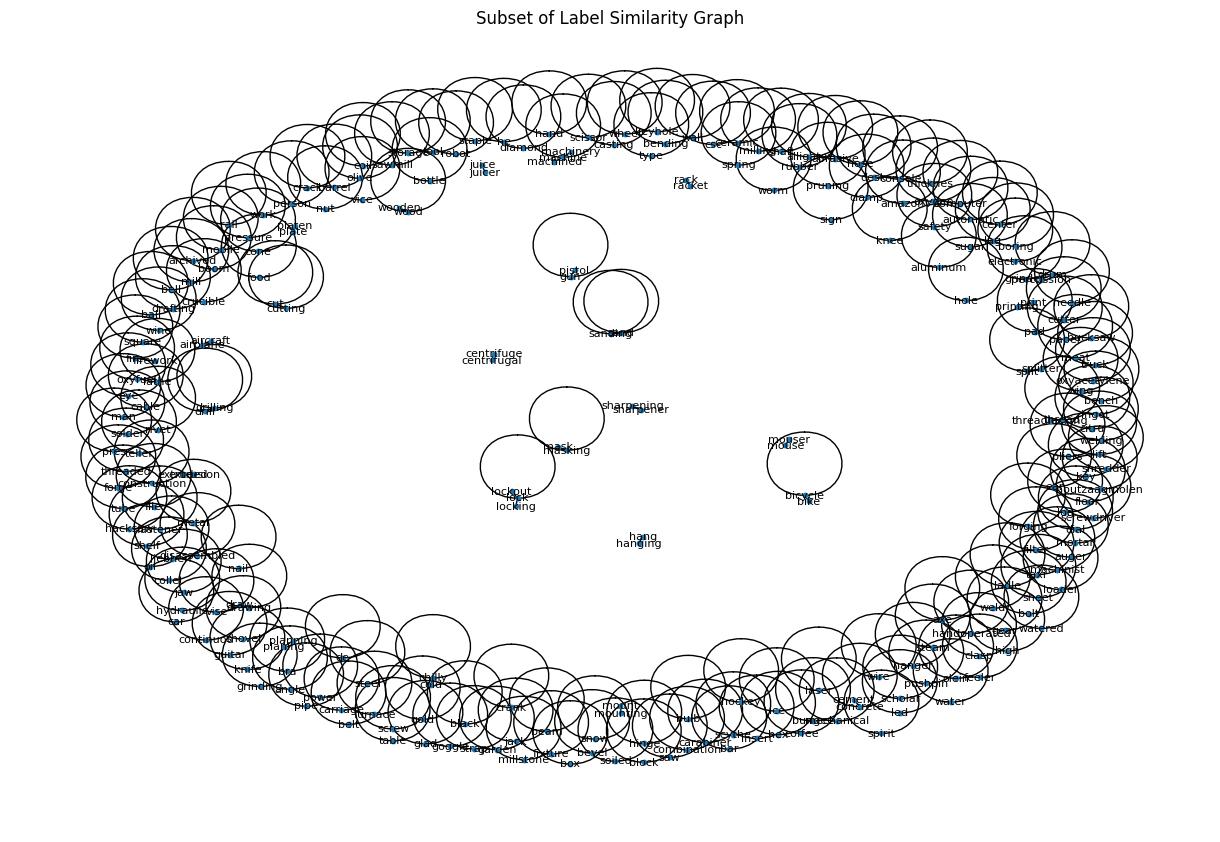

In [ ]:
strings = communities
G = create_graph(strings, 0.8, model)  # Increased threshold for stricter similarity
communities = get_communities(G)

for i, comm in enumerate(communities):
    print(f"Community {i+1}: {list(comm)}")  # Print first 5 members of each community

# Create a dictionary to map each label to its corresponding community
label_to_community = {}
for i, comm in enumerate(communities):
    for label in comm:
        label_to_community[label] = i

df['label_community'] = df['label'].map(label_to_community)

# Visualize a subset of the graph
subset = list(G.nodes())  # Visualize only the first 100 nodes
subgraph = G.subgraph(subset)

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(subgraph)
nx.draw(subgraph, pos, with_labels=True, node_size=10, font_size=8)
plt.title("Subset of Label Similarity Graph")
plt.show()